# **Bienvenido**
**Clasificación de preguntas de clientes - Santander 🏅 TOP 3** 

Este colab te lleva a explorar los modelos NLP que me ayudaron a clasificar miles
de preguntas en más de 300 categorías diferentes.


# Introducción

Luego de varias semanas,  el esfuerzo trajo frutos, un día antes de finalizar la competencia logré posicionarme en el top 10, y luego de varios intentos (muchos) logré afinar mis parámetros y modelos para posicionarme en el top 3. 

Una competencia desafiante y que disfruté mucho. Estoy muy agredecido con todos los involucrados en la organización de este tipo de competencias y en especial con todos los que me apoyaron a seguir intentando.


# **Exploración de los datos 🔬**

Antes de describir paso a paso todas las etapas de mi estrategia es necesario echar un vistazo a los datos.

In [2]:
# Descargamos y leemos los datos de entrenamiento
!wget -q -O train.csv https://drive.google.com/u/0/uc?id=1SvVbsYUpKphC3NuU4y7JDYsDJxYT61Yl&export=download
import pandas as pd

train_data = pd.read_csv('train.csv', sep='|')
train_size = len(train_data)
train_data.head(5)

,Pregunta,Intencion
0,como puedo trabajar en santander rio,Cat_102
1,pagar tarjeta visa querer reintegro,Cat_350
2,pagar tarjeta naranja sistema,Cat_132
3,no se debitó la primera cuota del plan de bien...,Cat_129
4,abonar tarjeta credito,Cat_342


## Información sobre las clases:
Vamos a conocer la distribución de las clases:

In [3]:
print('Total de clases: ' , len(train_data['Intencion'].unique()))

Total de clases:  352


In [4]:
category_freq = train_data['Intencion'].value_counts()
category_freq = pd.DataFrame({'n':  category_freq.values, 'Percentage': category_freq.apply(lambda x: '{0} %'.format(x*100/train_size))})

print('Cantidad de preguntas por clase')
print(category_freq.head(3), '\n...\n')
print(category_freq.tail(3))

Cantidad de preguntas por clase
           n            Percentage
Cat_132  600  2.9844807003581377 %
Cat_293  567    2.82033426183844 %
Cat_1    493  2.4522483087942697 % 
...

         n              Percentage
Cat_205  3  0.014922403501790688 %
Cat_24   2  0.009948269001193792 %
Cat_104  1  0.004974134500596896 %


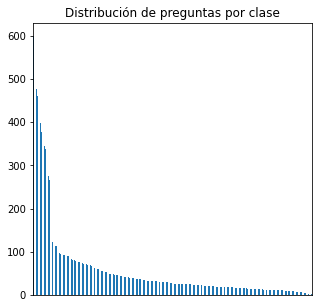

In [5]:
import matplotlib
%matplotlib inline

fig, axes = matplotlib.pyplot.subplots(figsize=(5, 5), nrows=1, ncols=1)
category_freq['n'].plot(kind='bar', title='Distribución de preguntas por clase').get_xaxis().set_ticks([]);

⚠️ La categoría con más preguntas posee 600 entradas, mientras que la categoría con menos preguntas posee sólo 1. El dataset está muy desbalanceado como podemos observar en la gráfica anterior.

A partir de esta información podemos considerar estratégias para lidiar con datasets desbalanceados.

## Información sobre las preguntas

También podemos obtener información acerca de las preguntas, para conocer un poco más el dataset

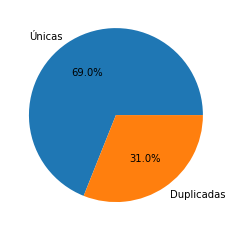

In [6]:
unique_q = train_data.groupby(["Pregunta", 'Intencion']).filter(lambda x: len(x) == 1)
duplicate_q = train_data.groupby(["Pregunta", 'Intencion']).filter(lambda x: len(x) > 1)
matplotlib.pyplot.pie((len(unique_q)*100/train_size, len(duplicate_q)*100/train_size),
                            labels=['Únicas', 'Duplicadas'],
                            autopct='%1.1f%%');

Aunque un 31% del dataset son preguntas repetidas, entrenar con o sin las preguntas repetidas no afectó considerablemente el performance de los modelos.

Ahora vamos a explorar la distribución de palabras y caracteres dentro de las preguntas:

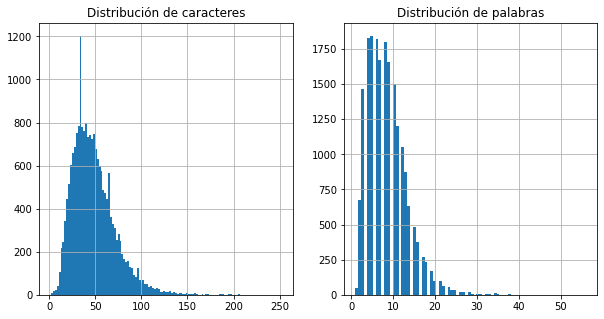

In [7]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

train_data['length'] = train_data['Pregunta'].apply(len)
train_data['length_tokens'] = train_data['Pregunta'].apply(lambda x : len(tokenizer.tokenize(x)))

fig, axes = matplotlib.pyplot.subplots(figsize=(10, 5), nrows=1, ncols=2)

train_data['length'].hist(bins=121, ax=axes[0]);
train_data['length_tokens'].hist(bins=80, ax=axes[1]);

axes[0].title.set_text('Distribución de caracteres');
axes[1].title.set_text('Distribución de palabras');

Esta información es útil para conocer la cantidad de tokens y posteriormente limitar la representación numérica de las preguntas.

## Contenido de las preguntas
Ahora echemos un vistazo a las palabras con más y menos frecuencia

In [8]:
!pip install wordcloud

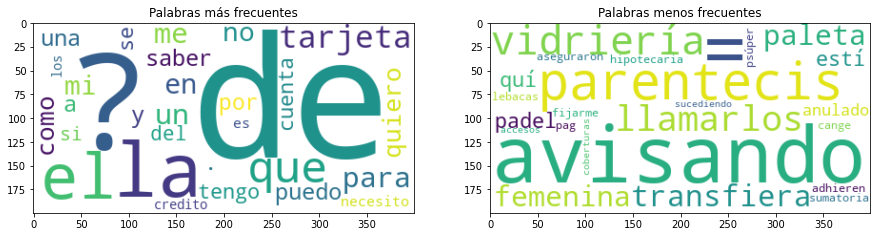

In [9]:
from wordcloud import WordCloud

from collections import Counter
train_data['tokens'] = train_data['Pregunta'].apply(lambda x : tokenizer.tokenize(x))
dic = Counter()

for tokens in train_data.tokens.values:
  dic.update(tokens)

def getWordcloud(data):
  return WordCloud(background_color ='white', min_font_size = 10).generate_from_frequencies(data)

wordcloud1 = getWordcloud(dict(dic.most_common(30)))
wordcloud2 = getWordcloud(dict(dic.most_common()[-30:]))

fig, axes = matplotlib.pyplot.subplots(figsize=(15, 15), nrows=1, ncols=2)
axes[0].imshow(wordcloud1, interpolation='bilinear')
axes[1].imshow(wordcloud2, interpolation='bilinear')

axes[0].title.set_text('Palabras más frecuentes')
axes[1].title.set_text('Palabras menos frecuentes')

Esto nos brinda información sobre qué palabras podemos descartar, así como la presencia de stop words en el dataset.


---


Ahora, como parte de la exploración, el siguiente paso fue explorar la relación entre las palabras.

Para ello voy a utilizar Gensim y Fastext

In [10]:
import gensim
model_words = gensim.models.FastText(sentences=train_data.tokens.values, min_count=5, size=100, workers=3, window=5, sg=1)

Con el modelo entrenado, ahora podemos hacer preguntas interesantes como por ejemplo, palabras similares

In [11]:
model_words.wv.most_similar('credito', topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('ccredito', 0.9579350352287292),
 ('cred', 0.9370944499969482),
 ('credit', 0.9251407384872437),
 ('crédito', 0.9221587777137756),
 ('dito', 0.9074308276176453)]

In [12]:
model_words.wv.most_similar('banking', topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('bankin', 0.9960318803787231),
 ('hombanking', 0.9918783903121948),
 ('bankig', 0.9900574088096619),
 ('homebanking', 0.9838123321533203),
 ('onlinebanking', 0.9715108275413513)]

Esta relación entre palabras nos da ideas de los errores más comunes que cometen los clientes al formular las preguntas, más adelante veremos como usamos esta información como parte de una estrategia para mejorar los modelos.



---

Como resultado del analisis anterior también sería interesante encontrar qué tanto está cubierto nuestro universo de palabras en un cuerpo pre entrenado. Es decir, cuantas de las palabras escritas en las preguntas aparecen en el vocabulario de modelos entrenados en cuerpos como Wikipedia, en este caso utilizaremos: Spanish Billion Word Corpus and Embeddings


In [13]:
# FastText embeddings from SBWC 300dm
!wget -q --no-clobber http://dcc.uchile.cl/~jperez/word-embeddings/fasttext-sbwc.vec.gz
!gunzip fasttext-sbwc.vec.gz

In [14]:
import numpy as np
MATRIX_VECTOR = 'fasttext-sbwc.vec'
embeddings_index = {}

f = open(MATRIX_VECTOR,  'r', encoding='utf-8')
for i, line in enumerate(f):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
f.close()

Ahora que contamos con el vocabulario preentrenado, podemos ver cuales de nuestras palabras aparecen en él y cuáles no:

In [15]:
unknown_words = []
for word, i  in dic.items():
  if embeddings_index.get(word) is None: 
    unknown_words.append(word)

print('Palabras desconocidas:')
for word_index in range(min(len(unknown_words), 15)):
  print(unknown_words[word_index])

print('\nTotal: ', len(unknown_words), ' of ', len(dic.items()), '. Coverage: ', (len(dic.items())-len(unknown_words))*100/len(dic.items()), '%')

Palabras desconocidas:
?
hombamnkin
.
ayudás
invercion
hablilitacion
ccredito
dnrap
buscartenencias
conumos
25
%.
!
depocitaron
aadnatage_

Total:  859  of  6342 . Coverage:  86.45537685272785 %


Como podemos observar este método nos ayuda a encontrar errores en las preguntas, así como las palabras únicas del dataset. Además nos informa que más del 80% de las palabras del dataset se encuentran en el vocabulario de SBWC.

## Conclusiones de la exploración de datos 📃


📌 El dataset está desbalanceado.

📌 Existe una gran cantidad de preguntas repetidas, con igual intención y con diferente intención.

📌 La cantidad de caracteres por pregunta ronda aproximadamente entre (40, 60).

📌 La cantidad de palabras por pregunta ronda aproximadamente entre (8, 15).

📌 Existe una gran cantidad de stopwords frecuentes.

📌 Existen palabras con frecuencia 1, que posiblemente no sean representativas.

📌 Existen signos de puntuación, algunas palabras llevan tilde y otras no.

📌 Algunas palabras similares se deben a errores ortográficos.

📌 80% De las palabras existen en un cuerpo pre entrenado


# Estrategia ⚔️
Mi pequeña experiencia en competencias similares de clasificación de texto me sirvieron como base para atacar el problema, realicé una etapa de procesamiento luego entrené modelos utilizando Redes Neuronales Recurrentes y la cereza del pastel, un modelo utilizando BERT (Bidirectional Encoder Representations from Transformers) pre entrenado en español (BETO)


Describo el flujo de esta estrategia en el siguiente gráfico:

<br />

<img src="https://i.imgur.com/VtKd7pK.png"/> 




# Etapa 1: Preprocesamiento 🔨

### Preprocesamiento para Redes Neuronales Recurrentes:
En base al análisis anterior realicé un preprocesamiento que minimizaba la cantidad de entradas en el diccionario y normalizaba todas las palabras en las preguntas. Este pipeline fue evolucionando de acuerdo a los resultados de entrenamiento, por ejemplo, aunque hay una gran cantidad de stopwords, entrenar el modelo sin stopwords desminuyó la efectividad del mismo por lo tanto se conservan.

<br />

<img src="https://i.imgur.com/1HKXMF1.png" width="400"/>

<br />

## Preprocesamiento para BERT:
Luego de varias pruebas, concluí que el mejor resultado lo obtenía si no aplicaba ningún cambio sobre las palabras excepto por el Tokenizer pre entrenado en BETO. El mismo se encarga de normalizar y hacer lowercase de las palabras, así como agregar los separadores y máscaras correspondientes.

<br />

<img src="https://i.imgur.com/54rO7T9.png" width="400" />

<br />



# **Etapa 2: Entrenamiento 🚴**

## Intentos previos:
**El primer intento:**
Mi primer intento lo llevé a cabo utilizando un modelo perceptron multicapa bastante simple, donde los features era n-gram vectors computados usando TFIDF que fueron obtenidos luego de limpiar los datos basandome en el análisis anterior. Sin embargo no logré obtener un score mayor a **0.70**.

**El segundo:**
Mi segundo intento fue hecho con Embeddings, donde usé como base un modelo que hice anteriormente para la clasificación de títulos en la competencia de Mercadolibre de 2019, con este modelo logré alcanzar el puesto 18 de un total de 219 participantes en dicha competencia. 

Al usar Embeddings logré alcanzar un puntaje de **0.78**. Al parecer Word Embeddings era una estratégia que podría rendir frutos, luego de sucesivos envíos utilizando Embeddings pre entrenados en distintos cuerpos en español, concluí que el mejor modelo que obtuve fue entrenando mis propios Embeddings.

Todos los modelos de embeddings utilizaron el pre procesamiento descrito anteriormente.

**Tabla de puntajes para los modelos iniciales:**

Modelo | Balanced Accuracy
-- | --
n-grams | **0.70**
Embeddings | **0.78**

## Modelos LSTM y GRU
Luego de investigar cómo mejorar el rendimiento del modelo qué solo usaba Embeddings y una capa clasificadora, introduje una capa LSTM y GRU en dos modelos en paralelo, esto me catapultó al top 15.

Arquitectura de los modelos GRU y LSTM (Alrededor de **1,526,472** parámetros):

<img src="https://i.imgur.com/MT21cDo.png" width="300"/>


**Tabla de puntajes para los mejores modelos individuales basados en Word Embeddings**

<br /> 


Modelo | Balanced Accuracy
-- | --
Embeddings | **0.78**
Embeddings + Bidirectional LSTM | **0.8071**
Embeddings + Bidirectional GRU | **0.8056**

## BERT 🍒
Mi ultima esperanza para romper el techo alcanzado por RNN, utilicé BERT (Alrededor de **110,121,568** parámetros) pre entrenado en español (BETO)

<br />
<img src="https://i.imgur.com/a5vjwHu.png" width="130" />

Mi mejor puntaje obtenido para BERT fue de **0.8447**


## **Sobre las observaciones del dataset**
Gran parte de la información obtenida en el análisis de datos sirvió como base para decidir el preprocesamiento a usar en el entrenamiento de los modelos. Aunque no todas las conclusiones aportaron directamente en el preprocesamiento, sirvieron como pistas para conocer qué información es más valiosa en el dataset.

## **Sobre el entrenamiento**
Los modelos basados en RNN fueron entrenados utilizando KFolds, específicamente StratifiedKFold, una variación que conserva las proporciones de las clases ya que como descubrimos en la exploración de datos el dataset está bastante desbalanceado, junto a la ayuda de Sklearn calculé los pesos por clase para penalizar las clases con menor o mayor representación. Realicé 10 folds, lo que divide el dataset en 1/10 para validar y 9/10 para entrenar por fold. Obteniendo así un Balanced Accuracy en promedio de **0.80** para ambos modelos basados en RNN.


---
Al igual que los otros modelos entrené BERT utilizando KFolds, esto se tomó su tiempo aún utilizando TPUs.

Para detener el entrenamiento de todos los modelos utilicé Early Stopping, basandome en el mejor validation accuracy del mismo y guardando los mejores pesos. 


Una vez identificado un buen parámetro para el número de épocas y el learning rate de los mejores modelos, entrené los modelos con todo el dataset, sin separar entre training y validation, esto tiene sus pros y contras, sin embargo con el propósito de la competencia resultó en un mejor performance en el leaderboard.


## Gráficos de Entrenamiento para 1 fold

## Accuracy:


<table>
  <tr>
    <td>
      <div>
      <div>LSTM</div>
      <div><img src="https://i.imgur.com/DOcYN55.png" width="400"></div>
      </div>
    </td>
    <td>
      <div>
      <div>GRU</div>
      <div><img src="https://i.imgur.com/F0y6nxp.png" width="400"></div>
      </div>
    </td>
    <td>
      <div>
      <div>BERT</div>
      <div><img src="https://i.imgur.com/dlHbnT6.png" width="400"></div>
      </div>
    </td>
   </tr> 
</table>

## Loss:


<table>
  <tr>
    <td>
      <div>
      <div>LSTM</div>
      <div><img src="https://i.imgur.com/ZpFbBaq.png" width="400"></div>
      </div>
    </td>
    <td>
      <div>
      <div>GRU</div>
      <div><img src="https://i.imgur.com/zOL5XyL.png" width="400"></div>
      </div>
    </td>
    <td>
      <div>
      <div>BERT</div>
      <div><img src="https://i.imgur.com/hxH4FeZ.png" width="400"></div>
      </div>
    </td> 
</table>

## **Selección de Hyperparametros**

Para encontrar los **hyperparametros** que mejor resultado me brindaron entrené más de 50 modelos realizando grid search con diferentes valores, tanto en Kaggle como en Google Colab.

Fue un gran reto encontrar los valores que evitaran overfittear los modelos pero que me brindaran una puntación estable, por otro lado tuve que luchar contra los números random ya que ni en Google Colab, ni en Kaggle pude fijarlos.

## Para Redes Neuronales Recurrentes:
Representé los tokens en **120** dimensiones, tanto LSTM como GRU contienen como units el doble de dimensiones de la capa de Embeddings.

La capa densa intermedia contiene **512** units, con la función Relu.

Además limité el largo de las palabras a **30**, y agregué padding a las palabras con menor cantidad. Conservé cada palabra del diccionario, incluso aquellas con frecuencia igual a 1.

Como optimizador usé **Adam** con un learning rate igual a **0.0001**. 

## Para BERT:
No logré utilizar Weight Decay Regularization, sin embargo fijar el learning rate en un valor igual a **3e-5** me dió buenos resultados. De igual forma limité las palabras a un largo de 30. Probé con distintos valores para la capa Dropout y **0.35** resultó ser un buen número Al igual que para RNN el optimizador que usé fue **Adam**.



# **Etapa 3: Predicción 🔮**

Un dia antes de finalizar la competencia probé mi ultima opción, **ensamblar** los distintos modelos, esto me funcionó en una competencia de clasificación de audio para la Universidad Nacional del Litoral donde logré obtener el segundo lugar.

Mi primer ensamblaje consistió en mi mejor modelo basado en LSTM junto a mi mejor modelo basado en BERT con 0.5 de peso cada uno:

`Assembled = BERT * 0.5 + LSTM * 0.5`

El resultado fue ir directo al top 10, un balanced accuracy de **0.8533** 🎉

Luego de esto seguí mejorando los modelos individuales y armé el ensamblado final el cual consistió en lo siguiente:

Modelo | Weight | Individual Score
-- | -- | -- |
Embeddings + Bidirectional LSTM | 0.3 | 0.8071668160237432
Embeddings + Bidirectional GRU | 0.2 | 0.8056236171806629
BERT | 0.5 | 0.8447457866471272

Esto es:

`Assembled2 = BERT * 0.5 + LSTM * 0.3 + GRU * 0.2`


Y el resultado final: 

.
.
.
.

## Un Balanced Accuracy de **0.8663** == Top 3 en el public leaderboard.

# **Intentos de optimización 🛸**
Durante el entrenamiento de los modelos desarollé varias soluciones para intentar mejorar la calidad de los modelos, las cuales listo a continuación:

* **Hierarchical classification**

  Intenté agrupar las categorías con menor presencia en una uníca categoría, y así entrenar un modelo (n-k)+1 donde n es el numero total de categorías y k es la cantidad de categorías con menos presencia. Posteriormente intentar crear un clasificador especializado en las k categorias con menor representación. Sin embargo este approach no resultó.
*  **Fine Tunning y Transfer Learning con Word Embeddings Existentes**

  Intenté congelar la primera capa de mis modelos LSTM y GRU. Y usar los pesos inicializados con los valores existentes en cuerpos pre entrenados como SBWC, logré un BACC de 0.75, posteriormente descongelé la capa e intenté entrenar de nuevo, sin embargo no logré mejorar este score. 

*   **Corrección automática de errores ortográficos utilizando Levenshtein distance**

  Este approach no funcionó del todo ya que existen muchas palabras únicas en el dataset, y una gran cantidad de errores son practicamente indescifrables. Hacer una corrección manual de los errores más frecuentes podría mejorar el rendimiento.

* **Words embeddings usando Train y Test dataset**

  Intente entrenar mi propio modelo Fastext para usar Word Embeddings y hacer fine-tuning utilizando palabras del train y el test dataset. Sin embargo este approach no dió buenos resultados.

* **Agregar más capas a BERT**

  Intenté combinar varias arquitecturas usando como capa previa a BERT sin embargo no tuve buenos resultados.

* **Contextual augmentation**

  Intente crear preguntas a partir de modelos como el mismo BERT, donde el objetivo era agregar o reemplazar una palabra de las preguntas basandome en el contexto, este approach no mejoró significativamente el score.

  La pregunta "**cuáles son los requisitos para obtener un préstamo?**" se convertía en:
  
  *cuáles son los requisitos para poder obtener un nuevo préstamo ?*


*   **Intentar balancear el dataset creando preguntas**

  Desarrollé un pipeline de traducción descrito a continuación

  <img src="https://i.imgur.com/qwmPQkh.png" width="250"/>

 
  Este algoritmo convertía la frase: 
  
  **cómo puedo hacer para enviarles mi currículum?**


  En las siguientes frases:
  - *¿Cómo puedo enviarte mi CV?*
  - *¿Cómo puedo enviar mi currículum?*
  - *¿Cómo puedo enviarle mi CV?*

Sin embargo no todas las traducciones fueron tan buenas y no logré obtener un buen score usanto esta técnica.

# **Próximos pasos y posibles mejoras**
* Implementar AdamW y encontrar una mejor combinación de valores para el learning rate de BERT puede ayudar ganar un mejor valor en el entrenamiento.

* Para los modelos LSTM es posible utilizar los datos de Word Embeddings para corregir los errores ortográficos presentes y disminuír más el diccionario.

* Encontrar mejores valores para los pesos de los modelos ensamblados utilizando una funcion que minimice el loss en las predicciones de los modelos.

* Es posible que alguna de las técnicas usadas como la de traducción funcione para augmentar el dataset, ya que un solo sample para una clase no es suficiente para entrenar.

* Me gustaría haber intentado invertir más tiempo en mejorar los modelos que en lidiar con el desbalance y la falta de ejemplos en las clases. Porque el modelo final deja casi intacto el dataset.

* Con algo más de tiempo también se podría obtener más información sobre las palabras del set de prueba, con la intención de mejorar el modelo.


# **El valor que aporta mi solución**
  A través de la concepción de la solución en sí, fuí descubriendo información que puede ser útil para abordar futuros problemas de clasificación, por otro lado, los defectos encontrados en los modelos así como las ideas, sirven como punto de inicio para mejorar modelos existentes o iterar sobre el dataset para mejorarlo y así construir un modelo que logre generalizar mucho más y sea totalmente confiable en un ambiente de producción. Por mi parte esta solución forma parte de una etapa de aprendizaje que me ha llevado a descubrir y explorar nuevos conocimientos en cuanto al campo de NLP.

# **Conclusiones**

Siempre es importante apuntar a un modelo que generalize de la mejor manera, fue un reto lidiar con el dataset, que aunque es chico, presenta distintas complicaciones. Entrenar con todo el dataset no es recomendado en modelos que requieran posterior observación o cuyo propósito sea ser desplegados en aplicaciones para la vida real, es decir, deban ser calificados en tiempo real con datos nuevos, sin embargo debido a la poca representación de algunas clases, usar esta técnica sirvió para propósitos de la competencia.

La exploración de métodos para augmentar, limpiar y mejorar el dataset son la fundación y las bases de los ajustes para la posterior decisión de los modelos utilizados, por otro lado, haciendo uso de GPU's y TPU's se pueden lograr entrenar modelos en paralelo mediante plataformas como Google Colaboratory con el fin de encontrar los mejores valores para los hyperparametros.

Finalmente el ensemble de modelos juega un rol crucial en esta solución, ya que si cada modelo se aproxima por un lugar distinto a la solución, al unirlos utilizando Weighted Average Ensemble, en teoria estaríamos acercandonos a la solución final gracias al ensamble realizado con los pesos propuestos.

---

Muchas gracias.

## **Referencias**
BETO: Spanish BERT https://github.com/dccuchile/beto

BERT for Tensorflow: https://huggingface.co/transformers/model_doc/bert.html

LSTM Layers: https://keras.io/api/layers/recurrent_layers/lstm/

Kfolds for imbalanced datasets: https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/

Diagramas hechos utilizando la herramienta: https://app.diagrams.net/

AdamW https://www.fast.ai/2018/07/02/adam-weight-decay/

Clasificación de títulos para MercadoLibre: https://github.com/jeffersonlicet/ml-titles-classification

Clasificación de Audio para la Universidad del Litoral: https://github.com/jeffersonlicet/litoral-audio-classification